In [1]:
#The following file paths are all absolute paths. You can replace them with relative paths at runtime, and the files are located in their respective folders.
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import gym
import matplotlib.pyplot as plt
import random
import argparse
from collections import OrderedDict
from copy import copy
from tqdm import tqdm, trange
import scipy
import scipy.linalg
from scipy.integrate import odeint
import sys
import os
import csv 
sys.path.append("/media/serena/study/Vscode_works/python_Vscode/mamba/Nonlinear_LSPN/Predict_Model_Train/")
sys.path.append("/media/serena/study/Vscode_works/python_Vscode/mamba/Nonlinear_LSPN/utility_LSPN/")
from LSPN_test import LSPN_Mamba
os.environ['KMP_DUPLICATE_LIB_OK'] = "TRUE"


/home/serena/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
Methods = ["KoopmanDerivative","KoopmanRBF",\
            "KNonlinear","KNonlinearRNN","KoopmanU",\
            "KoopmanNonlinearA","KoopmanNonlinear",\
            "KNonlinearmamba"]
Method_names = ["KoopmanDerivative","KoopmanRBF",\
            "KDNN","KRNN","DKUC(ours)",\
            "DKAC(ours)","DKN(ours)",\
            "KNonlinearmamba"]

In [3]:
def read_rossler_dataset_original_shape(file_path):
    data = np.load(file_path)
    return data

def eval_err(suffix,method_index):
    # method_index = 0
    method = Methods[method_index]
    root_path = "/media/serena/study/Vscode_works/python_Vscode/mamba/Nonlinear_LSPN/DATA/Mamba_data_raw/"+suffix
    print(method)
    if method.endswith("KNonlinear"):
        import Learn_Knonlinear as lka
    elif method.endswith("KNonlinearRNN"):
        import Learn_Knonlinear_RNN as lka
    elif method.endswith("KoopmanNonlinear"):
        import Learn_KoopmanNonlinear_with_KlinearEig as lka
    elif method.endswith("KoopmanNonlinearA"):
        import Learn_KoopmanNonlinearA_with_KlinearEig as lka
    elif method.endswith("KoopmanU"):
        import Learn_Koopman_with_KlinearEig as lka
    elif method.endswith("KNonlinearmamba"):
        import Learn_Knonlinear_mamba_luolunzi as lka   
    for file in os.listdir(root_path):
        if file.startswith(method+"_"+"van_der_pol") and file.endswith(".pth"):
            model_path = file  
    dicts = torch.load(root_path+"/"+model_path,map_location=torch.device('cpu'))
    state_dict = dicts["model"]
    if method.endswith("KNonlinearRNN"):
        net = lka.Network(input_size=3,output_size=3,hidden_dim=128, n_layers=3)
    elif method.endswith("KNonlinearmamba"):
        net = LSPN_Mamba(
        d_model=1, 
        d_state=8, 
        d_conv=4, 
        expand=4,  
    ).to("cuda")
    net.load_state_dict(state_dict)
    # net.cuda()
    net.double()
    Samples = 5000
    steps = 50
    random.seed(2022)
    np.random.seed(2022)
    times = 4 
    max_loss_all = np.zeros((times,steps-1))
    mean_loss_all = np.zeros((times,steps-1))
    with torch.no_grad():
        for i in trange(times, desc="predicting_van_der_pol", unit="times"):
            X_original_shape = read_rossler_dataset_original_shape('/media/serena/study/Vscode_works/python_Vscode/mamba/Nonlinear_LSPN/utility_LSPN/van_der_pol_data.npy')
            test_data = X_original_shape[-Samples:, :steps, :]
            np.save("/media/serena/study/Vscode_works/python_Vscode/mamba/Nonlinear_LSPN/DATA/LSPN_predict_data/van_der_pol"+suffix+".npy",test_data)
            max_loss,mean_loss = lka.K_loss(test_data,net)
            max_loss_all[i] = max_loss.reshape(-1)
            mean_loss_all[i] = mean_loss.reshape(-1)
    max_mean = np.mean(max_loss_all,axis=0)
    max_std = np.std(max_loss_all,axis=0)
    mean_mean =  np.mean(mean_loss_all,axis=0)
    mean_std =  np.std(mean_loss_all,axis=0)
    np.save("/media/serena/study/Vscode_works/python_Vscode/mamba/Nonlinear_LSPN/DATA/LSPN_rossler_data/van_der_pol"+suffix+"_"+method+".npy",np.array([max_mean,max_std,mean_mean,mean_std]))
    return max_mean,max_std,mean_mean,mean_std

In [4]:
suffix = "mamba_testvan_der_pol2"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

for i in [7]:
    #i = 2
    eval_err(suffix,method_index=i)


KNonlinearmamba


predicting_van_der_pol: 100%|██████████| 4/4 [00:00<00:00, 27.22times/s]


Text(0.5, 1.0, 'van_der_pol')

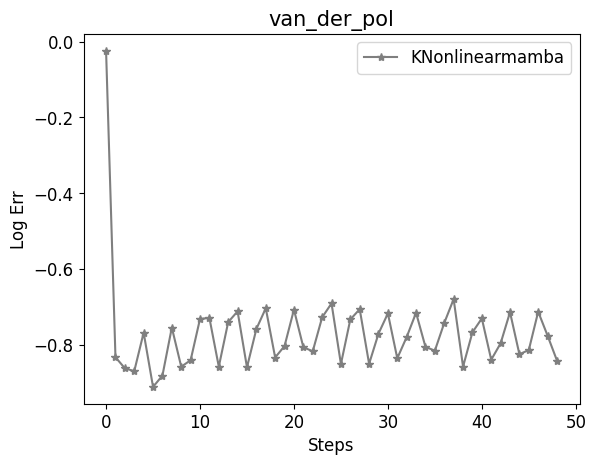

In [5]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
font = {'size'   : 12}

plt.rc('font', **font)
# markers = ['*','+','*','+','*','+','*']
title = "van_der_pol"
# compare = "max"
compare = "mean"
for i in [7]:
    file_path = "/media/serena/study/Vscode_works/python_Vscode/mamba/Nonlinear_LSPN/DATA/LSPN_rossler_data/van_der_pol"+suffix+"_"+Methods[i]+".npy"
    data = np.load(file_path)
    plt.plot(np.log10(data[2]),'*-',color = colors[i],label=Methods[i],linewidth=1.5)
plt.legend()
# plt.grid(linestyle='-.')
plt.xlabel("Steps",fontsize=12)
plt.ylabel("Log Err",fontsize=12)
plt.title(title,fontsize=15)
# plt.savefig("D:/毕业设计/论文/pictures/sizeNN/"+env_name+"_TEST_"+compare+"_new1.png",dpi=400)

In [6]:
# colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
# font = {'size'   : 12}

# plt.rc('font', **font)
# # markers = ['*','+','*','+','*','+','*']
# #env_name = "DampingPendulum"
# #env_name = "CartPole-v1"
# env_name = "MountainCarContinuous-v0"
# # env_name = "Pendulum-v1"
# # env_name = "Franka"
# # env_name = "DoublePendulum"
# title = env_name
# compare = "max"
# compare = "mean"
# #i = 2
# #plt.plot(np.log10(data[0]),'*-',color = colors[i],label="Layer Depth of NNs = {}".format(i+1),linewidth=1.5)
# for i in range(2,7):
#     file_path = "D:/毕业设计/中期/Python/MPC_trykoopman/results/difcompare_data/"+env_name+"_"+Methods[i]+"layer3.npy"
#     data = np.load(file_path)
#     plt.plot(np.log10(data[2]),'*-',color = colors[i],label=Methods[i],linewidth=1.5)
# plt.legend()
# # plt.grid(linestyle='-.')
# plt.xlabel("Steps",fontsize=12)
# plt.ylabel("Log Err",fontsize=12)
# plt.title(title,fontsize=15)
# plt.savefig("D:/毕业设计/论文/pictures/sizeNN/"+env_name+"_TEST_"+compare+"_new2.png",dpi=400)